In [1]:
import numpy as np
import nrrd
from os.path import *
from pylab import *
from matplotlib.ticker import FixedLocator
from JSONread import *
from density_function import *
import json

DATA_FOLDER = "data/"
OUTPUT_FOLDER = "output/"

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
annotation, h = nrrd.read(join(DATA_FOLDER, "annotations.nrrd"))
rv = json.loads(open(join(DATA_FOLDER, "volumes_25.json"), "r").read())
voxel_volume = 25**3/1.0e9
neu_dens, h = nrrd.read(join(DATA_FOLDER, "neu_density.nrrd"))
num_neurons = json.loads(open(join(DATA_FOLDER, "neuron_counts.json"), "r").read())
jsontextfile = open(join(DATA_FOLDER, "brain_regions.json"), "r")
jsoncontent = json.loads(jsontextfile.read())
search_children(jsoncontent['msg'][0])

In [4]:
dens_GAD, h = nrrd.read(join(OUTPUT_FOLDER, "densities_GAD.nrrd"))
dens_GAD_std = json.loads(open(join(OUTPUT_FOLDER, "std_GAD.json"), "r").read())
dens_PV, h = nrrd.read(join(OUTPUT_FOLDER, "densities_PV.nrrd"))
dens_PV_std = json.loads(open(join(OUTPUT_FOLDER, "std_PV.json"), "r").read())
dens_SST, h = nrrd.read(join(OUTPUT_FOLDER, "densities_SST.nrrd"))
dens_SST_std = json.loads(open(join(OUTPUT_FOLDER, "std_SST.json"), "r").read())
dens_VIP, h = nrrd.read(join(OUTPUT_FOLDER, "densities_VIP.nrrd"))
dens_VIP_std = json.loads(open(join(OUTPUT_FOLDER, "std_VIP.json"), "r").read())

In [5]:
# Convert cell/mm3 to cell/voxel
dens_GAD *= voxel_volume
dens_PV *= voxel_volume
dens_SST *= voxel_volume
dens_VIP *= voxel_volume

In [6]:
dens_sum = dens_PV + dens_SST + dens_VIP

In [7]:
uniques = find_unique_regions(annotation, 
                        id_to_region_dictionary_ALLNAME, 
                        region_dictionary_to_id_ALLNAME,
                        region_dictionary_to_id_ALLNAME_parent, 
                        name2allname)

children, order_ = find_children(uniques, id_to_region_dictionary_ALLNAME, is_leaf,
                                  region_dictionary_to_id_ALLNAME_parent, 
                                  region_dictionary_to_id_ALLNAME)
uniques = uniques[np.argsort(order_)] # order from leaf to biggest regions

In [8]:
names = []
corrected = []
num_GADs = []
num_SSTs = []
num_VIPs = []
num_PVs = []
low_std_GADs = []
up_std_GADs = []
low_std_sums = [] 
up_std_sums = []
volumes = []

apply_correction = True
epsilon = 1e-3 # precision for corrections
for id_reg in uniques:
    region_name = id_to_region_dictionary_ALLNAME[id_reg]
    if is_leaf[region_name]:
        filter_ = annotation==id_reg
    else:
        ids_reg = np.concatenate((children[region_name], [id_reg]))
        filter_ = np.in1d(annotation, ids_reg).reshape(annotation.shape)
    
    num_GAD = np.sum(dens_GAD[filter_])
    num_sum = np.sum(dens_sum[filter_]) 
    if num_sum-num_GAD>1 and str(id_reg) in dens_GAD_std:
        low_GAD = dens_GAD_std[str(id_reg)][0]
        up_GAD = dens_GAD_std[str(id_reg)][1]
        low_sum = dens_PV_std[str(id_reg)][0] + dens_VIP_std[str(id_reg)][0] + dens_SST_std[str(id_reg)][0]
        up_sum = min(dens_PV_std[str(id_reg)][1] + dens_VIP_std[str(id_reg)][1] + dens_SST_std[str(id_reg)][1], np.sum(neu_dens[filter_]))
        if low_GAD > num_GAD:
            print("GAD Error with " + region_name)
            print("low: " + str(low_GAD), "num: " + str(num_GAD))
            low_GAD = num_GAD
        if up_GAD < num_GAD:
            print("GAD Error with " + region_name)
            print("num: " + str(num_GAD), "up: " + str(up_GAD))
            up_GAD = num_GAD
        
        if low_sum > num_sum:
            print("Sum Error with " + region_name)
            print("low: " + str(low_sum), "num: " + str(num_sum))
            low_sum = num_sum
        if up_sum < num_sum:
            print("Sum Error with " + region_name)
            print("num: " + str(num_sum), "up: " + str(up_sum))
            up_sum = num_sum
        
        if apply_correction and low_sum<=up_GAD: # Still correct
            corrected.append(True)
            # Process ratio of std to correct
            ratio  = (num_sum - num_GAD) / (num_sum - num_GAD + up_GAD - low_sum)  
            
            num_GAD = num_GAD + ratio * (up_GAD - num_GAD)
            low_GAD = max(low_sum, dens_GAD_std[str(id_reg)][0])
            
            loc_mean_markers = np.array([np.sum(dens_PV[filter_]), np.sum(dens_SST[filter_]), np.sum(dens_VIP[filter_])])
            loc_max_markers = np.array([dens_PV_std[str(id_reg)][1], dens_SST_std[str(id_reg)][1], dens_VIP_std[str(id_reg)][1]])
            
            marker_sums = np.ones(loc_mean_markers.shape) * num_sum
            ratios = np.divide(loc_mean_markers, marker_sums, out=np.zeros_like(loc_mean_markers), where=marker_sums!=0)
            loc_max_markers = np.minimum(ratios * up_GAD, loc_max_markers)
            loc_mean_markers = ratios * (num_GAD - epsilon) # The placing algorithm will place at least num_GAD - epsilon cells  
            
            loc_filter = np.copy(filter_) 
            if not is_leaf[region_name]:
                # Remaining neurons to place in the whole region
                loc_filter = loc_filter * (annotation != id_reg)
                num_placed_GAD = np.sum(dens_GAD[loc_filter])
                num_placed = np.array([np.sum(dens_PV[loc_filter]), np.sum(dens_SST[loc_filter]), np.sum(dens_VIP[loc_filter])])
                
                # number of neuron to place in regions where annotation = id_reg
                loc_filter = annotation == id_reg
                num_GAD = max(num_GAD - num_placed_GAD, 0.)
                loc_mean_markers = np.maximum(loc_mean_markers - num_placed, 0.)
            else:
                num_placed = [0., 0., 0.]
                num_placed_GAD = 0.
            loc_neu_dens = neu_dens[loc_filter]
            sum_dens = np.zeros(annotation.shape)[loc_filter]
            
            # GAD new density becomes top_density for SST, PV, VIP 
            loc_neu_dens = fill_density_dataset(num_GAD, np.ones(annotation.shape)[loc_filter], loc_neu_dens, None, epsilon=epsilon)
            dens_GAD[loc_filter] = np.copy(loc_neu_dens)
            num_GAD = np.sum(loc_neu_dens) + num_placed_GAD
            low_GAD = min(low_GAD, num_GAD)
            up_GAD = max(up_GAD, num_GAD)
            
            dens_placed = fill_density_dataset(loc_mean_markers[0], np.ones(annotation.shape)[loc_filter], loc_neu_dens - sum_dens, None, epsilon=epsilon)
            dens_PV[loc_filter] = np.copy(dens_placed)
            num_sum = np.sum(dens_placed)
            sum_dens += dens_placed
            
            dens_placed = fill_density_dataset(loc_mean_markers[1], np.ones(annotation.shape)[loc_filter], loc_neu_dens - sum_dens, None, epsilon=epsilon)
            dens_SST[loc_filter] = np.copy(dens_placed)
            num_sum += np.sum(dens_placed)
            sum_dens += dens_placed
            
            dens_placed = fill_density_dataset(loc_mean_markers[2], np.ones(annotation.shape)[loc_filter], loc_neu_dens - sum_dens, None, epsilon=epsilon)
            dens_VIP[loc_filter] = np.copy(dens_placed)
            num_sum += np.sum(dens_placed) + np.sum(num_placed)
            low_sum = min(low_sum, num_sum)
            up_sum = max(np.sum(loc_max_markers), num_sum)
        else:
            corrected.append(False)
        names.append(region_name)
        num_GADs.append(num_GAD)
        num_SSTs.append(np.sum(dens_SST[filter_]))
        num_PVs.append(np.sum(dens_PV[filter_]))
        num_VIPs.append(np.sum(dens_VIP[filter_]))
        
        low_std_GADs.append(num_GAD - low_GAD)
        up_std_GADs.append(up_GAD - num_GAD)
        low_std_sums.append(num_sum - low_sum)
        up_std_sums.append(up_sum - num_sum)
        volumes.append(rv[region_name])
filter_ = np.argsort(names)
names = np.array(names)[filter_]
corrected = np.array(corrected)[filter_]
volumes = np.array(volumes)[filter_]
num_GADs = np.array(num_GADs)[filter_]
num_SSTs = np.array(num_SSTs)[filter_]
num_PVs = np.array(num_PVs)[filter_]
num_VIPs = np.array(num_VIPs)[filter_]
low_std_GADs = np.vstack((low_std_GADs, up_std_GADs))[:, filter_]
low_std_sums = np.vstack((low_std_sums, up_std_sums))[:, filter_]

Sum Error with |root|Basic cell groups and regions|Brain stem|Hindbrain|Medulla|Medulla, motor related|Lateral reticular nucleus|Lateral reticular nucleus, parvicellular part
low: 261.072130182867 num: 261.0721
Sum Error with |root|Basic cell groups and regions|Brain stem|Hindbrain|Medulla|Medulla, motor related|Medullary reticular nucleus|Medullary reticular nucleus, dorsal part
low: 17154.205146606597 num: 17154.203
GAD Error with |root|Basic cell groups and regions|Brain stem|Midbrain|Midbrain, sensory related|Inferior colliculus|Inferior colliculus, central nucleus
num: 8109.338 up: 8109.3375
Sum Error with |root|Basic cell groups and regions|Brain stem|Midbrain|Midbrain, sensory related|Inferior colliculus|Inferior colliculus, dorsal nucleus
low: 50206.25589875229 num: 50206.254
GAD Error with |root|Basic cell groups and regions|Brain stem|Midbrain|Midbrain, sensory related|Inferior colliculus|Inferior colliculus, external nucleus
num: 9590.251 up: 9590.25
Sum Error with |root|Bas

In [9]:
loc_names = np.copy(names)
for iname, name in enumerate(names):
    loc_names[iname] = allname2name[name]

In [10]:
# Percentage of GAD / number of neuron 
np.sum(dens_GAD)/np.sum(neu_dens) *100.

22.894434204731613

In [11]:
# Percentage of PV, VIP, SST / number of neuron 
np.sum(dens_sum)/np.sum(neu_dens) *100.

7.182885305731417

In [12]:
# Percentage of incorrect regions before correction
len(names) / len(uniques) * 100.

11.077235772357724

In [13]:
# Percentage of incorrect regions after correction
(len(names) - len(np.where(corrected)[0])) / len(uniques) *100

7.317073170731707

In [14]:
# Percentage of volume of the brain occupied by the region incorrect after correction
np.sum(volumes[np.where(~corrected)]) / rv[name2allname["Basic cell groups and regions"]] * 100.

14.981227571923556

In [15]:
# Percentage of neurons of the brain in the region incorrect after correction
np.sum([num_neurons[name] for name in names[np.where(~corrected)]]) / np.sum(neu_dens) * 100.

7.600405228839185

In [16]:
# Filter regions after correction
filter_ = np.ones(names.shape, dtype=bool)
# filter_ = np.zeros(names.shape, dtype=bool)
# for iname, name in enumerate(names):
#     if "Isocortex" in name:
#         filter_[iname] = True

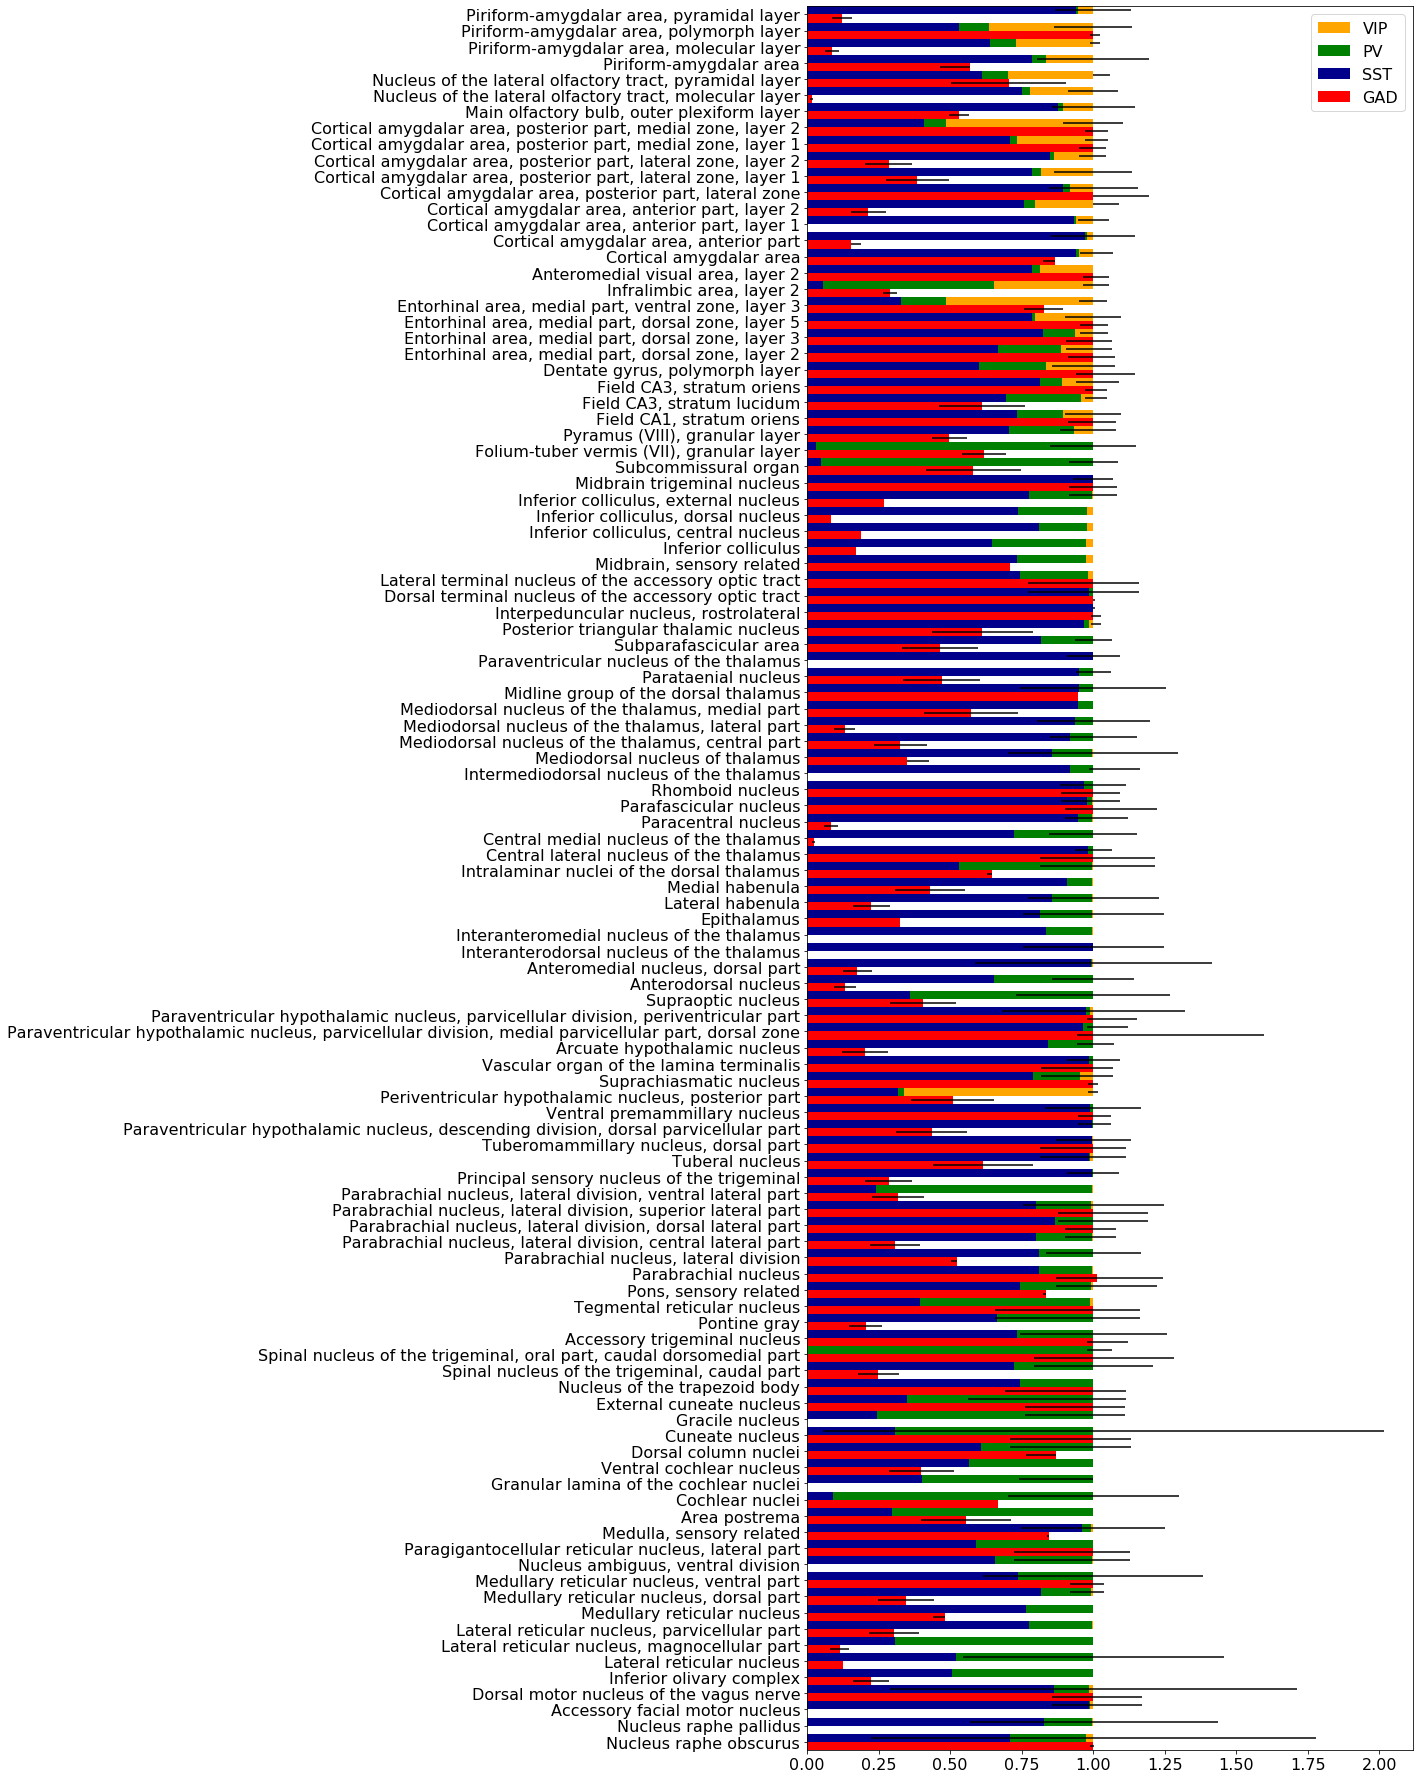

In [17]:
fig = figure(figsize=(20,25))
width = 0.5
sum_ = num_SSTs + num_PVs + num_VIPs
sum_ = sum_[filter_]
x = np.arange(len(sum_))
bar1 = barh(x-width/2.0, num_VIPs[filter_]/sum_, height=width, left=(num_SSTs[filter_] + num_PVs[filter_])/sum_, color = "orange", xerr=low_std_sums[:,filter_]/sum_)
bar2 = barh(x-width/2.0, num_PVs[filter_]/sum_, height=width, left=num_SSTs[filter_]/sum_, color = "green")
bar3 = barh(x-width/2.0, num_SSTs[filter_]/sum_, height=width, color = "darkblue")
bar4 = barh(x+width/2.0, num_GADs[filter_]/sum_, height=width, color = "red", xerr=low_std_GADs[:, filter_]/sum_)
# fig.axes[0].yaxis.set_major_locator(FixedLocator((x.astype(float)+0.5)[np.where(corrected[filter_])]))
# fig.axes[0].yaxis.set_tick_params(which='major', labelcolor='b')

legend((bar1[0], bar2[0], bar3[0], bar4[0]), ('VIP', 'PV', 'SST', 'GAD'))
yticks((x.astype(float)+0.5), loc_names[filter_])
ylim([0, len(x)-1])
tight_layout()
savefig(join(OUTPUT_FOLDER, 'Inconsistencies_GAD_sum.png'), dpi=400)

In [ ]:
# Excitatory density
exc_dens = neu_dens - dens_GAD

In [ ]:
# Ratio of excitatory/inhibitory neurons in the Isocortex
# This value might be tightly link to L1/L2 boundaries
ids_reg = np.concatenate((children[name2allname["Isocortex"]], [region_dictionary_to_id["Isocortex"]]))
filter_ = np.in1d(annotation, ids_reg).reshape(annotation.shape)
np.sum(dens_GAD[filter_])/np.sum(neu_dens[filter_])

In [ ]:
id_reg = region_dictionary_to_id["Cortical amygdalar area, posterior part, lateral zone"]
region_name = id_to_region_dictionary_ALLNAME[id_reg]
ids_reg = np.concatenate((children[region_name], [id_reg]))
filter_ = np.in1d(annotation, ids_reg).reshape(annotation.shape)